In [99]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math as m
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

def read_csv():
    #train = pd.read_csv('dss-regression-datasets/project-sberbank-housing-market-data/train.csv')
    train = pd.read_csv('treated_train_df.csv')
    return train


#Encoding Categorical Variables
def encode_cat(df):
    #get categorical(type='object') variable
    cat_var_df = df.select_dtypes(include=['object']).copy()
    
    
    cleanup_nums = {"product_type":{'OwnerOccupier' : 0, 'Investment' : 1},                
               "ecology": {'no data' : 0, 'poor' : 1, 'satisfactory' : 2, 'good' : 3, 'excellent' : 4}}
    
    #dummy encoding
    for i in cat_var_df.columns:        
        if cat_var_df[i].unique()[0] in ['no', 'yes']:
            cleanup_nums[i] = {'no':0, 'yes':1}
    
    #sub_area encoding
    sub_index = 0
    sub_area_enc_dict = {}
    for key in set(cat_var_df['sub_area'].values):
        sub_area_enc_dict[key] = sub_index
        sub_index += 1
    cleanup_nums['sub_area'] = sub_area_enc_dict
    
    try:
        cat_var_df.replace(cleanup_nums, inplace=True)
    except:
        pass
    
    df = df.drop(cat_var_df.columns, axis=1)
    df = pd.concat([df, cat_var_df], axis=1)
    return df


def encode_num(df):
    df['build_year']  = df['build_year'] - 2015
    return df


def dropping_outliers1(x, y):
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1)
    result = model.fit()
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (len(y) - 2)
    idx = np.where(cooks_d2 > fox_cr)[0]
    x = x.drop(x.index[idx])
    y = y.drop(y.index[idx])
    print("Function dropping_outliers :" + str(len(idx)) + ' rows have beed deleted')
    return x, y
    
def backw_eli(x, y):
    result_df_reg1 = pd.DataFrame()
    num_high_pvalue = 1000    
    x1 = x
    while num_high_pvalue > 0:
        x1 = sm.add_constant(x1)
        model = sm.OLS(y, x1).fit()
        
        sorted_pvalues = model.pvalues.sort_values(ascending=False)
        if sorted_pvalues.index[0] == 'const':
            x1 = x1.drop(sorted_pvalues.index[1], 1)
        else:
            x1 = x1.drop(sorted_pvalues.index[0], 1)
            
        num_high_pvalue = len(model.pvalues[model.pvalues >= 0.005])
        
    model = sm.OLS(y, x1).fit()
    result_df_reg1['col_name'] = model.pvalues.index.values
    result_df_reg1['col_slope'] = model.params.values
    result_df_reg1['col_pvalue'] = model.pvalues.values
    result_df_reg1['col_std_error'] = model.bse.values
        
    return result_df_reg1, model, y, x1

#influence = result.get_influence()

# call data set
train = read_csv()                               
#encode cat variable
train_df_enc = encode_cat(train)
#encode num variable & drop Null rows
train_df = encode_num(train_df_enc).dropna(how='any')
#variable deviding (dep, cat, num & dum)
dep_df = train_df[['id', 'timestamp', 'price_doc']]
cat_df = train_df[['state', 'sub_area', 'ecology', 'material']]
num_dum_df = train_df.drop([*dep_df.columns, *cat_df.columns], axis=1)
y = dep_df['price_doc']   
y_log = np.log(y)

#num_dum_df, dep outliers cleasing 1
num_dum_df_do1, y_do1 = dropping_outliers1(num_dum_df, y)


print(train_df.shape)

Function dropping_outliers :241 rows have beed deleted
(4291, 292)


In [18]:
print(dep_df.shape)
print(cat_df.shape)
print(num_dum_df.shape)

(4245, 3)
(4245, 3)
(4245, 286)


In [58]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
     
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [61]:
rmsle(y_predict, y_do1_reg1)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


0.51418578095745959

# Pval 0.01 
result_df_do1_reg1, model_do1, y_do1_reg1, num_dum_df_x1_do1_reg1 = backw_eli(num_dum_df_do1, y_do1)

*data* treated
0.03 : 0.708, df63 0.01 : 0.697 df40

*data* non-treated
0.03 : 0.724 df 81
0.01 : 0.722 df75

In [77]:
result_df_do1_reg1, model_do1, y_do1_reg1, num_dum_df_x1_do1_reg1 = backw_eli(num_dum_df_do1, y_do1)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [78]:
print(model_do1.summary())
y_predict = model_do1.predict(num_dum_df_x1_do1_reg1)
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_do1_reg1, y_predict)))
print('R2 : ', model_do1.rsquared, '\n')
print('Adj. R2 : ', model_do1.rsquared_adj, '\n')

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     230.2
Date:                Thu, 19 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:04:34   Log-Likelihood:                -65561.
No. Observations:                4050   AIC:                         1.312e+05
Df Residuals:                    4009   BIC:                         1.315e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [80]:
model_do1.params.index

Index(['const', '0_6_female', '0_6_male', '7_14_male', 'basketball_km',
       'build_count_1971-1995', 'build_count_panel', 'cafe_avg_price_1500',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_4000',
       'cafe_count_1500_price_high', 'cafe_count_3000',
       'cafe_count_3000_price_1000', 'cafe_count_500_price_1500',
       'cafe_sum_1500_max_price_avg', 'cemetery_km', 'ekder_all',
       'exhibition_km', 'floor', 'full_sq', 'kitch_sq', 'leisure_count_1500',
       'leisure_count_2000', 'leisure_count_500', 'life_sq', 'metro_min_avto',
       'office_count_1500', 'office_count_3000', 'office_count_5000',
       'office_sqm_1500', 'preschool_quota', 'prom_part_5000',
       'railroad_station_avto_min', 'sport_count_2000', 'theater_km',
       'thermal_power_plant_km', 'ts_km', 'young_female', 'young_male',
       'product_type', 'radiation_raion'],
      dtype='object')

In [85]:
var_40_df = train_df_enc[['0_6_female', '0_6_male', '7_14_male', 'basketball_km',
       'build_count_1971-1995', 'build_count_panel', 'cafe_avg_price_1500',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_4000',
       'cafe_count_1500_price_high', 'cafe_count_3000',
       'cafe_count_3000_price_1000', 'cafe_count_500_price_1500',
       'cafe_sum_1500_max_price_avg', 'cemetery_km', 'ekder_all',
       'exhibition_km', 'floor', 'full_sq', 'kitch_sq', 'leisure_count_1500',
       'leisure_count_2000', 'leisure_count_500', 'life_sq', 'metro_min_avto',
       'office_count_1500', 'office_count_3000', 'office_count_5000',
       'office_sqm_1500', 'preschool_quota', 'prom_part_5000',
       'railroad_station_avto_min', 'sport_count_2000', 'theater_km',
       'thermal_power_plant_km', 'ts_km', 'young_female', 'young_male',
       'product_type', 'radiation_raion']]

In [86]:
var_40_df = var_40_df.dropna(how='any')

In [89]:
y_40 = train['price_doc'][var_40_df.index]

In [90]:
var_40_df_do, y_40_do = dropping_outliers1(var_40_df, y_40 )

Function dropping_outliers :535 rows have beed deleted


In [92]:
re_40, mod_40, y_reg_40, var_40_df_d_reg1 = backw_eli(var_40_df_do, y_40_do)


In [94]:
print(mod_40.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     594.5
Date:                Thu, 19 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:14:52   Log-Likelihood:            -1.6481e+05
No. Observations:               10273   AIC:                         3.297e+05
Df Residuals:                   10238   BIC:                         3.299e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

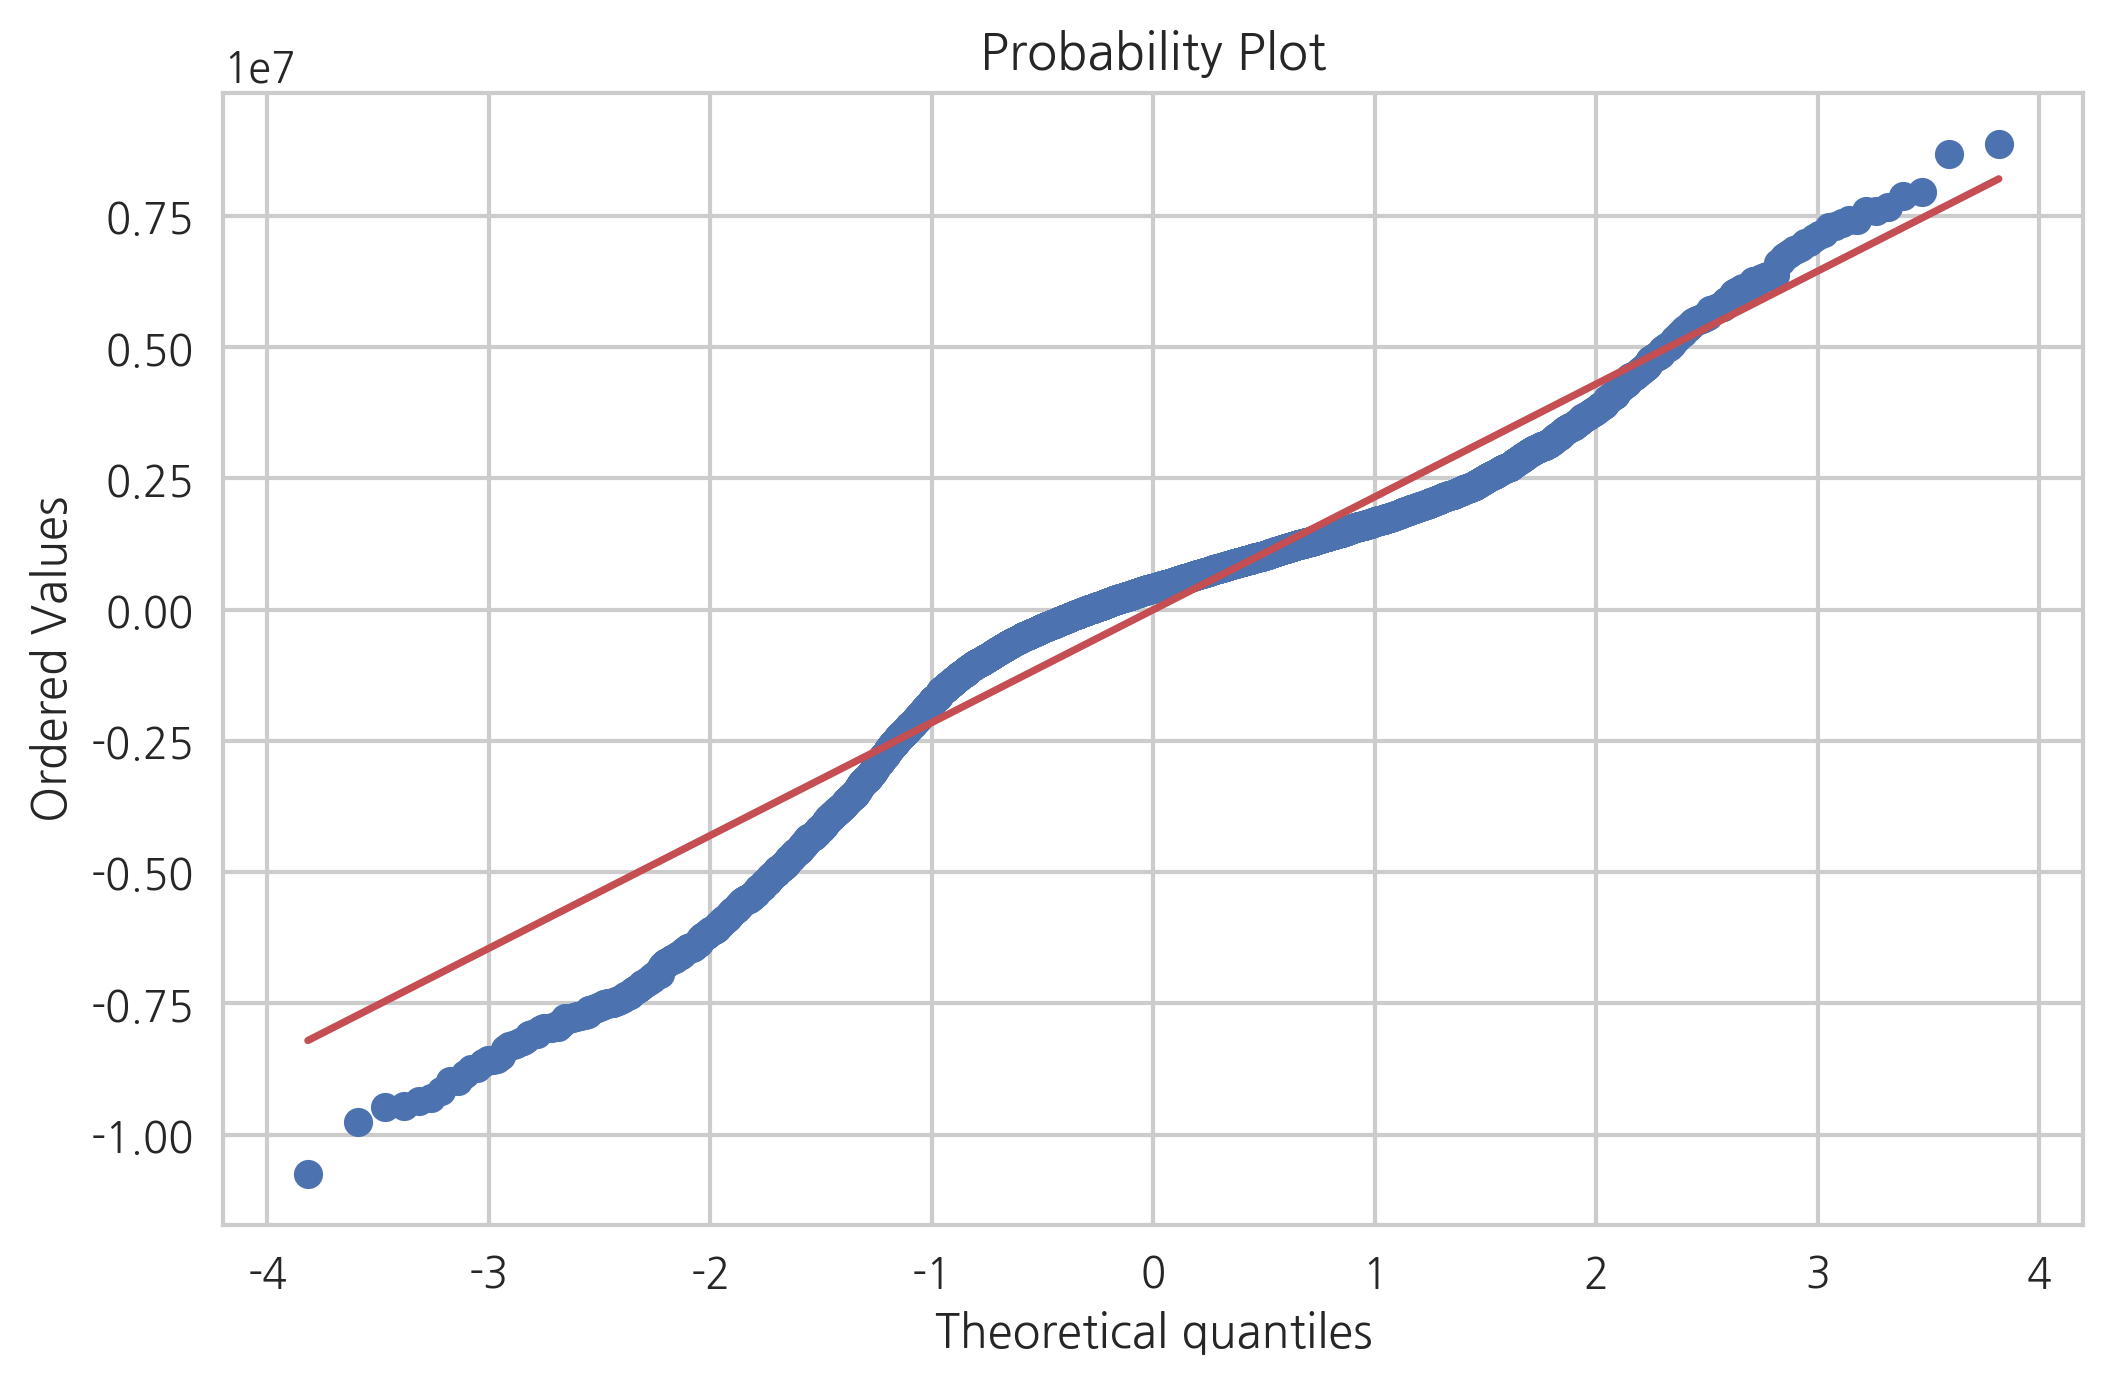

In [97]:
sp.stats.probplot(mod_40.resid, plot=plt)
plt.show()

In [98]:
test = sms.omni_normtest(mod_40.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 1730.115
P-value     :  0.000


In [100]:
re_40, mod_40, y_reg_40, var_40_df_d_reg1 = backw_eli(var_40_df_do, y_40_do)

In [101]:
print(mod_40.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     594.5
Date:                Thu, 19 Oct 2017   Prob (F-statistic):               0.00
Time:                        18:48:37   Log-Likelihood:            -1.6481e+05
No. Observations:               10273   AIC:                         3.297e+05
Df Residuals:                   10238   BIC:                         3.299e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [103]:
mod_40.params.index

Index(['const', '0_6_female', '0_6_male', 'basketball_km',
       'build_count_1971-1995', 'build_count_panel',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_4000',
       'cafe_count_1500_price_high', 'cafe_count_3000',
       'cafe_count_3000_price_1000', 'cafe_sum_1500_max_price_avg',
       'cemetery_km', 'ekder_all', 'exhibition_km', 'floor', 'full_sq',
       'leisure_count_1500', 'leisure_count_2000', 'life_sq', 'metro_min_avto',
       'office_count_1500', 'office_count_3000', 'office_count_5000',
       'office_sqm_1500', 'preschool_quota', 'prom_part_5000',
       'railroad_station_avto_min', 'sport_count_2000', 'theater_km',
       'thermal_power_plant_km', 'ts_km', 'young_female', 'product_type',
       'radiation_raion'],
      dtype='object')

In [105]:
var_40_df[['0_6_female', '0_6_male', 'basketball_km',
       'build_count_1971-1995', 'build_count_panel',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_4000',
       'cafe_count_1500_price_high', 'cafe_count_3000',
       'cafe_count_3000_price_1000', 'cafe_sum_1500_max_price_avg',
       'cemetery_km', 'ekder_all', 'exhibition_km', 'floor', 'full_sq',
       'leisure_count_1500', 'leisure_count_2000', 'life_sq', 'metro_min_avto',
       'office_count_1500', 'office_count_3000', 'office_count_5000',
       'office_sqm_1500', 'preschool_quota', 'prom_part_5000',
       'railroad_station_avto_min', 'sport_count_2000', 'theater_km',
       'thermal_power_plant_km', 'ts_km', 'young_female', 'product_type',
       'radiation_raion']].corr()

,0_6_female,0_6_male,basketball_km,build_count_1971-1995,build_count_panel,cafe_count_1000_price_1000,cafe_count_1500_price_4000,cafe_count_1500_price_high,cafe_count_3000,cafe_count_3000_price_1000,...,preschool_quota,prom_part_5000,railroad_station_avto_min,sport_count_2000,theater_km,thermal_power_plant_km,ts_km,young_female,product_type,radiation_raion
0_6_female,1.000000,0.993994,0.045827,0.619947,0.801393,-0.183230,-0.167651,-0.166638,-0.217815,-0.227930,...,0.846764,-0.195764,0.082019,-0.186830,0.417132,0.018893,-0.081524,0.991182,0.022804,-0.053379
0_6_male,0.993994,1.000000,0.058616,0.623069,0.810522,-0.194701,-0.179705,-0.175767,-0.227620,-0.237412,...,0.855829,-0.194547,0.077232,-0.192837,0.427663,0.020081,-0.066738,0.984481,0.043057,-0.053187
basketball_km,0.045827,0.058616,1.000000,0.103950,0.160893,-0.181324,-0.129306,-0.136777,-0.188627,-0.205292,...,0.269665,-0.313012,0.073452,-0.391845,0.208493,0.821819,0.745436,0.026764,-0.044530,-0.247940
build_count_1971-1995,0.619947,0.623069,0.103950,1.000000,0.601067,-0.155668,-0.116029,-0.131527,-0.184841,-0.195623,...,0.601949,-0.228298,0.090921,-0.264315,0.319345,0.145244,-0.102828,0.630668,0.022033,-0.039107
build_count_panel,0.801393,0.810522,0.160893,0.601067,1.000000,-0.255577,-0.231676,-0.248723,-0.302158,-0.310085,...,0.861558,-0.266765,0.145271,-0.297515,0.430331,0.108947,-0.004841,0.801588,0.109747,-0.080496
cafe_count_1000_price_1000,-0.183230,-0.194701,-0.181324,-0.155668,-0.255577,1.000000,0.927797,0.875798,0.959141,0.959254,...,-0.188275,-0.162869,-0.017640,0.774149,-0.300467,-0.113549,-0.039306,-0.128469,-0.287449,0.178999
cafe_count_1500_price_4000,-0.167651,-0.179705,-0.129306,-0.116029,-0.231676,0.927797,1.000000,0.912974,0.952229,0.941384,...,-0.160421,-0.194604,-0.002789,0.690684,-0.234282,-0.084455,-0.014439,-0.112803,-0.355186,0.185616
cafe_count_1500_price_high,-0.166638,-0.175767,-0.136777,-0.131527,-0.248723,0.875798,0.912974,1.000000,0.915460,0.905274,...,-0.165568,-0.194891,-0.026248,0.690610,-0.257363,-0.083054,-0.022533,-0.119679,-0.296228,0.169073
cafe_count_3000,-0.217815,-0.227620,-0.188627,-0.184841,-0.302158,0.959141,0.952229,0.915460,1.000000,0.997928,...,-0.223848,-0.154214,-0.042187,0.793562,-0.326776,-0.133220,-0.033862,-0.163934,-0.312639,0.185488
cafe_count_3000_price_1000,-0.227930,-0.237412,-0.205292,-0.195623,-0.310085,0.959254,0.941384,0.905274,0.997928,1.000000,...,-0.237920,-0.140415,-0.038247,0.808067,-0.342852,-0.145478,-0.044462,-0.174220,-0.304893,0.190931


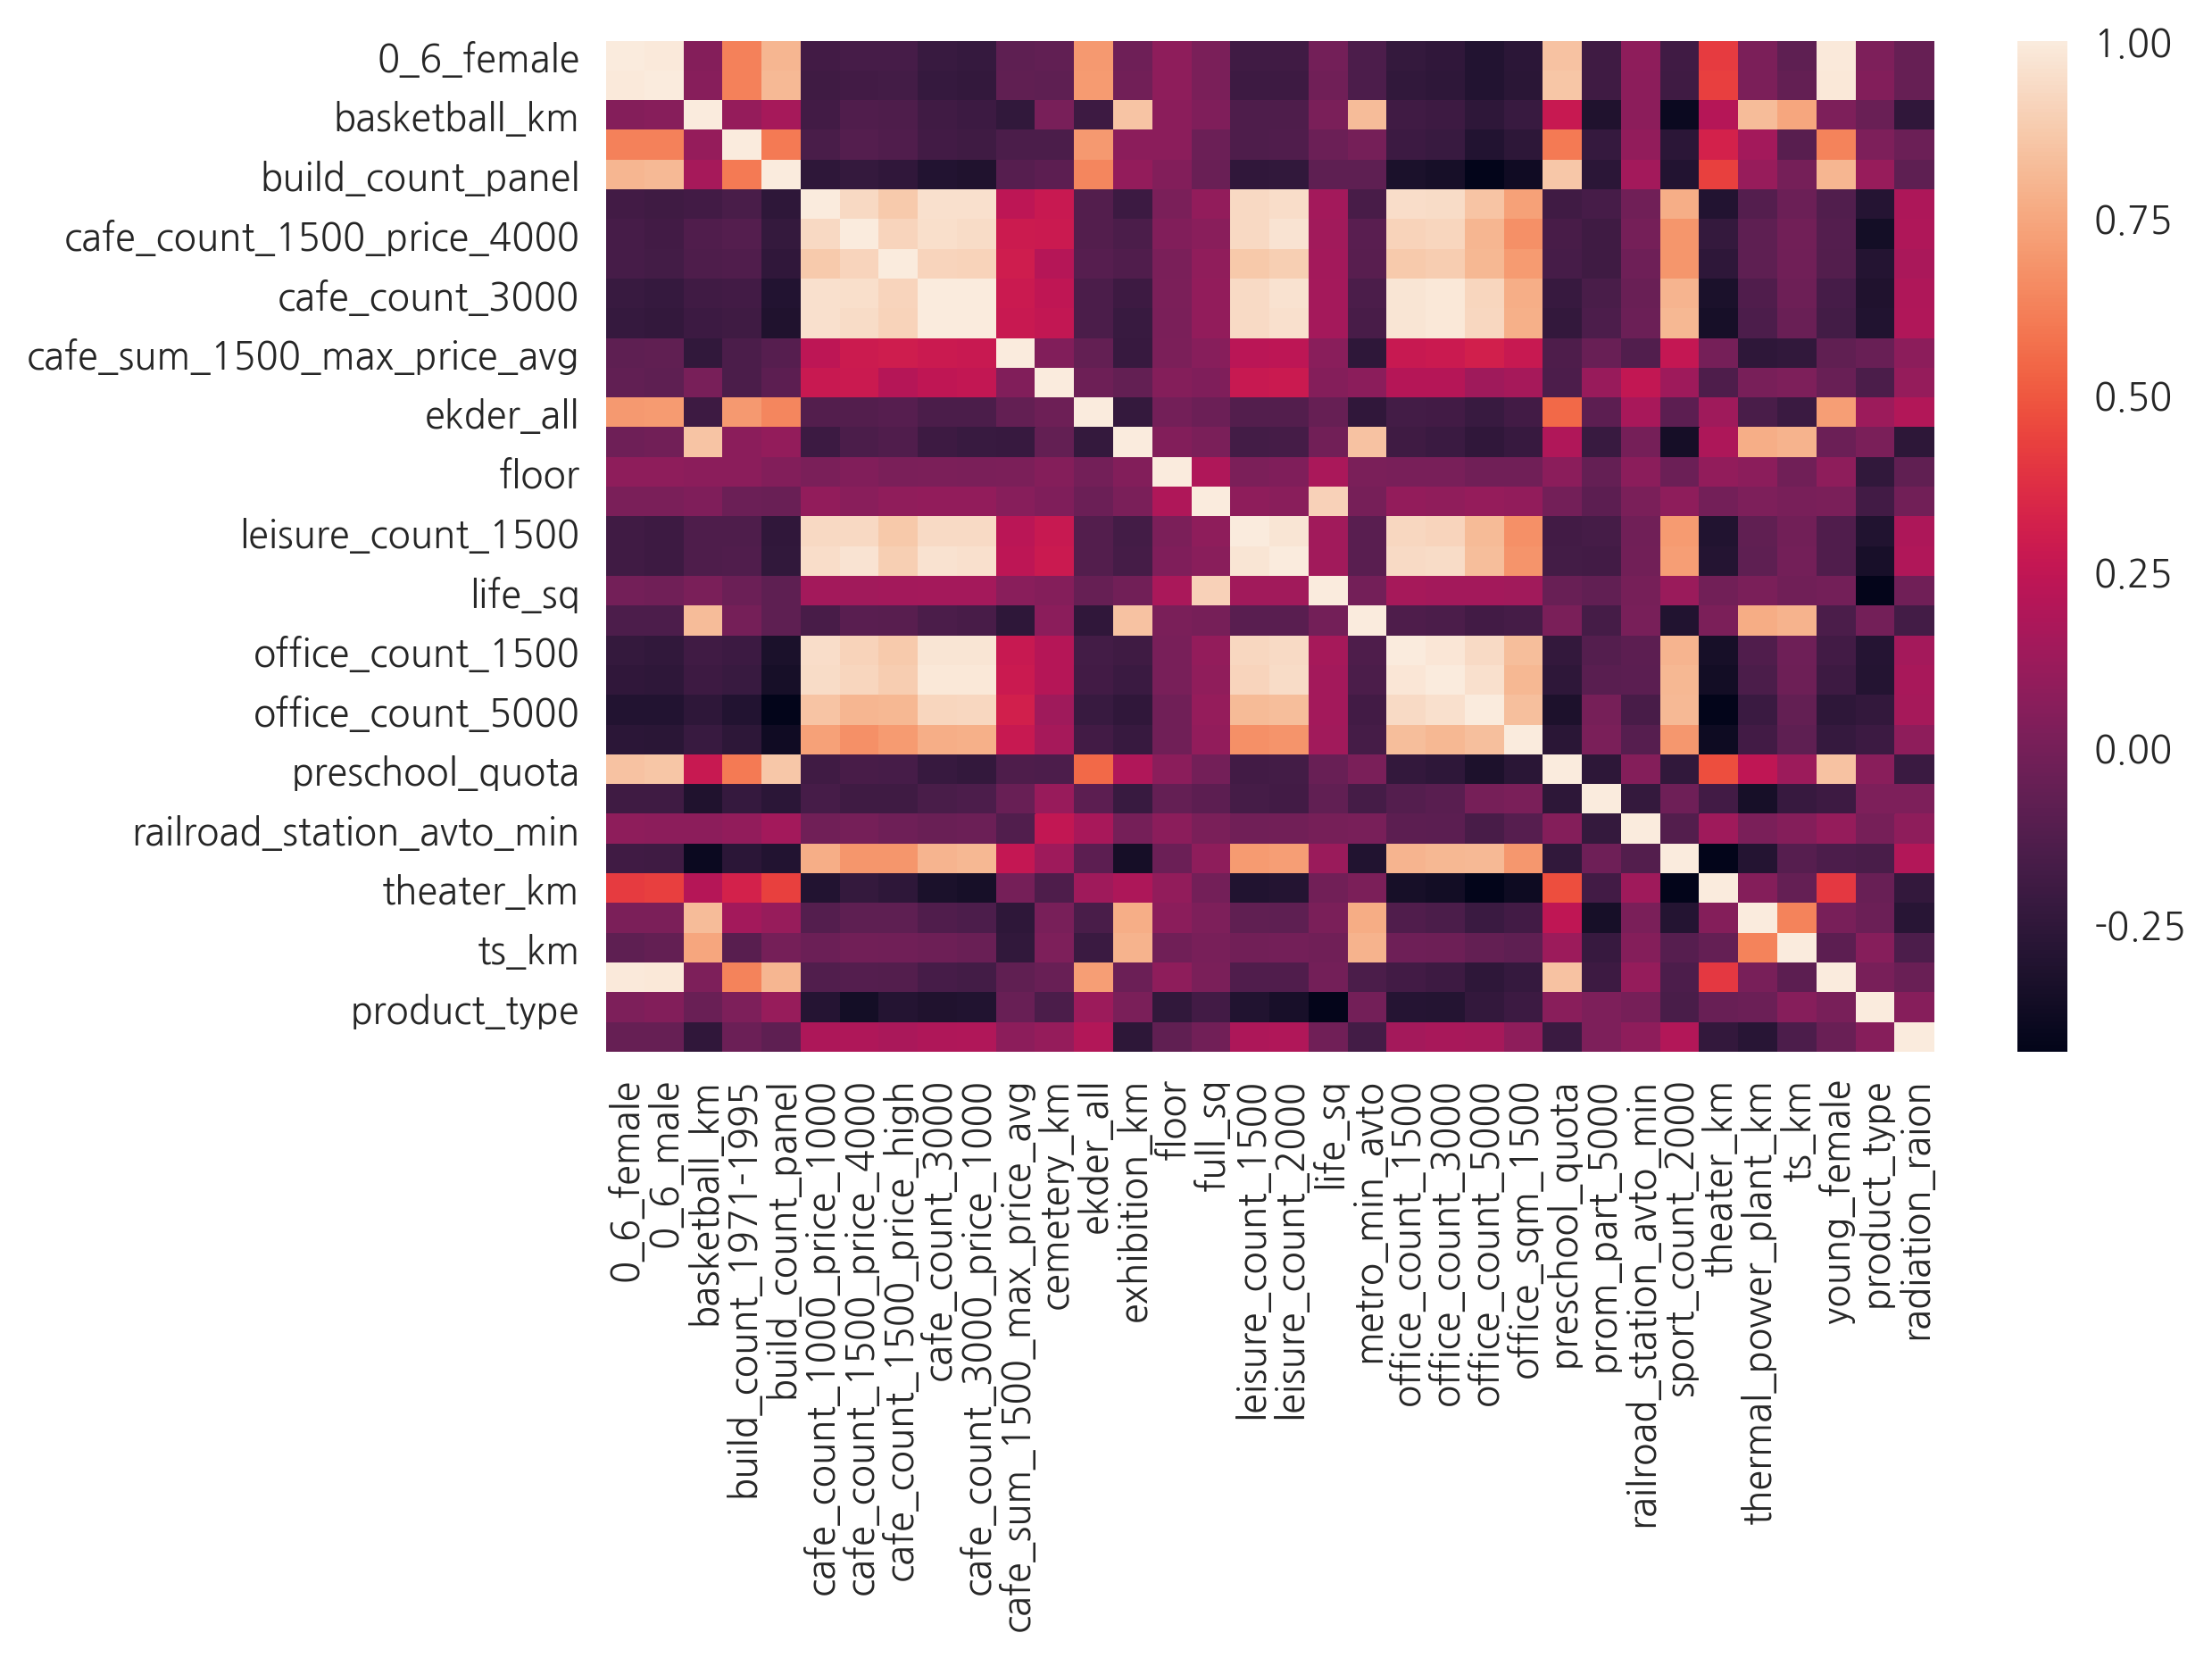

In [106]:
sns.heatmap(var_40_df[['0_6_female', '0_6_male', 'basketball_km',
       'build_count_1971-1995', 'build_count_panel',
       'cafe_count_1000_price_1000', 'cafe_count_1500_price_4000',
       'cafe_count_1500_price_high', 'cafe_count_3000',
       'cafe_count_3000_price_1000', 'cafe_sum_1500_max_price_avg',
       'cemetery_km', 'ekder_all', 'exhibition_km', 'floor', 'full_sq',
       'leisure_count_1500', 'leisure_count_2000', 'life_sq', 'metro_min_avto',
       'office_count_1500', 'office_count_3000', 'office_count_5000',
       'office_sqm_1500', 'preschool_quota', 'prom_part_5000',
       'railroad_station_avto_min', 'sport_count_2000', 'theater_km',
       'thermal_power_plant_km', 'ts_km', 'young_female', 'product_type',
       'radiation_raion']].corr())
plt.show()

In [1]:
type("a")

str